In [1]:
#!pip install -e ../Maccabee > /dev/null

In [2]:
!rm -rf _maccabee_compiled_code/

In [3]:
%reload_ext autoreload
%autoreload 1

In [4]:
import sys
sys.path.append("../Evaluation")

%aimport evaluation

from evaluation.analysis import *
from evaluation.persistence import *
from evaluation.plotting import *

%aimport evaluation.analysis
%aimport evaluation.plotting
%aimport evaluation.persistence


In [5]:
from maccabee.data_analysis.data_metrics import AXES_AND_METRIC_NAMES
from maccabee.constants import Constants
import maccabee.data_sources as data_sources
from maccabee.parameters import build_default_parameters

from maccabee.data_generation import DataGeneratingProcess, SampledDataGeneratingProcess, data_generating_method
from maccabee.data_generation.utils import evaluate_expression, CompiledExpression
# benchmarks
from maccabee.benchmarking import benchmark_model_using_concrete_dgp
from maccabee.benchmarking import benchmark_model_using_sampled_dgp
from maccabee.benchmarking import benchmark_model_using_sampled_dgp_grid

# genmatch
from maccabee.examples.genmatch import GenmatchDataGeneratingProcess, build_genmatch_datasource, GENMATCH_SPECS
from maccabee.examples.genmatch import LogisticPropensityMatchingCausalModel
from maccabee.examples.genmatch import GENMATCH_BINARY_COVAR_INDECES

In [6]:
import numpy as np
from collections import defaultdict
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use(['seaborn'])

import scipy.stats as st
import sympy as sp

In [7]:
COMPARISON_BENCHMARK = "G"

In [8]:
BASE_GENMATCH_DGP_PARAMS = {
  "OUTCOME_MECHANISM_COVARIATE_SELECTION_PROBABILITY": { 
        "LINEAR": 0.8,
        "POLY_QUAD": 0,
        "POLY_CUBIC": 0,
        "STEP_JUMP": 0,
        "STEP_KINK": 0,
        "INTERACTION_TWO_WAY": 0,
        "INTERACTION_THREE_WAY": 0,
  },
  "TREATMENT_EFFECT_HETEROGENEITY": 0,
  "ACTUAL_CONFOUNDER_ALIGNMENT": 0,
  "TARGET_PROPENSITY_SCORE": 0.5,
  "OUTCOME_NOISE_TAIL_THICKNESS": 1000,
  "SUBFUNCTION_CONSTANT_TAIL_THICKNESS": 1000,
  "TREATMENT_EFFECT_TAIL_THICKNESS": 1000
}

A_param_overrides = BASE_GENMATCH_DGP_PARAMS.copy()
A_param_overrides["TREAT_MECHANISM_COVARIATE_SELECTION_PROBABILITY"] = { 
    "LINEAR": 0.7,
    "POLY_QUAD": 0,
    "POLY_CUBIC": 0,
    "STEP_JUMP": 0,
    "STEP_KINK": 0,
    "INTERACTION_TWO_WAY": 0.0,
    "INTERACTION_THREE_WAY": 0,
}
A_param_overrides["ACTUAL_CONFOUNDER_ALIGNMENT"] = 0.285
  
C_param_overrides = BASE_GENMATCH_DGP_PARAMS.copy()
C_param_overrides["TREAT_MECHANISM_COVARIATE_SELECTION_PROBABILITY"] = { 
    "LINEAR": 0.7,
    "POLY_QUAD": 0.3,
    "POLY_CUBIC": 0,
    "STEP_JUMP": 0,
    "STEP_KINK": 0,
    "INTERACTION_TWO_WAY": 0.0,
    "INTERACTION_THREE_WAY": 0,
}
C_param_overrides["ACTUAL_CONFOUNDER_ALIGNMENT"] = -1

G_param_overrides = BASE_GENMATCH_DGP_PARAMS.copy()
G_param_overrides["TREAT_MECHANISM_COVARIATE_SELECTION_PROBABILITY"] = { 
    "LINEAR": 0.5,
    "POLY_QUAD": 0.7,
    "POLY_CUBIC": 0,
    "STEP_JUMP": 0,
    "STEP_KINK": 0,
    "INTERACTION_TWO_WAY": 0.22,
    "INTERACTION_THREE_WAY": 0,
}
G_param_overrides["ACTUAL_CONFOUNDER_ALIGNMENT"] = 0.571#0.15

GENMATCH_PARAM_OVERRIDES = {
    "A": A_param_overrides,
    "C": C_param_overrides,
    "G": G_param_overrides,
}

In [9]:
# Define axes and metrics to analyze
DATA_METRICS_SPEC = {
    Constants.AxisNames.OUTCOME_NONLINEARITY: [
#         "Lin r2(X_obs, Y)", # here
#         "Lin r2(X_true, Y)"
    ],
    Constants.AxisNames.TREATMENT_NONLINEARITY: [
        "Lin r2(X_obs, Treat Logit)",
#         "Lin r2(X_true, Treat Logit)",
#         "Log r2(X_obs, T)"
    ],
    Constants.AxisNames.PERCENT_TREATED: [
        #"Percent(T==1)"# here
    ],
#     Constants.AxisNames.BALANCE: [
#         "Wass dist X_true: T=1<->T=0",
#     ],
    Constants.AxisNames.ALIGNMENT: [
#         "Lin r2(Y, Treat Logit)", # here
#         "Lin r2(Y0, Treat Logit)"
    ],
#     Constants.AxisNames.TE_HETEROGENEITY: [
#         "std(TE)/std(Y)"
#     ]
}

In [10]:
N_CORES = 48
N_THREADS = 1

## Run MC Benchmarks

In [11]:
from maccabee.data_generation import ConcreteDataGeneratingProcess
DGPVariables = Constants.DGPVariables

MILD_NONLINEARITY = [2]
MODERATE_NONLINEARITY = [2, 4, 7]
MILD_NONADDITIVITY = [(1,3, 0.5), (2, 4, 0.7), (4,5, 0.5), (5,6, 0.5)]
MODERATE_NONADDITIVITY = [
        (1,3, 0.5),
        (2, 4, 0.7),
        (3,5, 0.5),
        (4,6, 0.7),
        (5,7, 0.5),
        (1,6, 0.5),
        (2,3, 0.7),
        (3,4, 0.5),
        (4,5, 0.5),
        (5,6, 0.5)]

GENMATCH_SPECS = {
    "A": ([], []),
    "B": (MILD_NONLINEARITY, []),
    "C": (MODERATE_NONLINEARITY, []),
    "D": ([], MILD_NONADDITIVITY),
    "E": (MILD_NONLINEARITY, MILD_NONADDITIVITY),
    "F": ([], MODERATE_NONADDITIVITY),
    "G": (MODERATE_NONLINEARITY, MODERATE_NONADDITIVITY)
}

GENMATCH_N_COVARS = 11
GENMATCH_BINARY_COVAR_INDECES = [1, 3, 5, 6, 8, 9]
GENMATCH_COVAR_NAMES = np.array([f"X{i}" for i in range(GENMATCH_N_COVARS)])

class GenmatchDataGeneratingProcess(ConcreteDataGeneratingProcess):
    def __init__(self, dgp_label, n_observations, data_analysis_mode, static_observations=False):

        super().__init__(n_observations, data_analysis_mode)

        quadratic_indeces, interactions_list = GENMATCH_SPECS[dgp_label]

        self.data_source = build_genmatch_datasource(n_observations)
        self.covar_symbols = np.array(sp.symbols(list(GENMATCH_COVAR_NAMES)))

        self.static_observations = static_observations
        self.static_covar_data = self.data_source.get_covar_df()

        self.assignment_weights = np.array(
            [0, 0.8, -0.25, 0.6, -0.4, -0.8, -0.5, 0.7, 0, 0, 0])

        self.outcome_weights = np.array(
            [-3.85, 0.3, -0.36, -0.73, -0.2, 0, 0, 0, 0.71, -0.19, 0.26])
        self.true_treat_effect = -0.4

        self.quad_terms_indeces = quadratic_indeces
        self.interactions_list = np.array(interactions_list)

        self._preprocess_functions()

    def _preprocess_functions(self):
        self.treatment_logit_terms = self.assignment_weights * self.covar_symbols


         # Add quad terms
        if len(self.quad_terms_indeces) > 0:
            self.treatment_logit_terms = np.append(
                self.treatment_logit_terms, (
                    self.assignment_weights[self.quad_terms_indeces] *
                    self.covar_symbols[self.quad_terms_indeces]**2))

        # Add interact terms
        if len(self.interactions_list) > 0:
            interact_1_indeces = self.interactions_list[:, 0].astype(int)
            interact_2_indeces = self.interactions_list[:, 1].astype(int)
            interact_weights = self.interactions_list[:, 2]

            self.treatment_logit_terms = np.append(
                self.treatment_logit_terms, (
                    self.assignment_weights[interact_1_indeces] *
                       self.covar_symbols[interact_1_indeces]*
                       self.covar_symbols[interact_2_indeces]*
                       interact_weights))

        self.treatment_logit_expression = np.sum(self.treatment_logit_terms)


        self.untreated_outcome_terms = self.outcome_weights * self.covar_symbols
        self.untreated_outcome_expression = np.sum(self.untreated_outcome_terms)

    @data_generating_method(DGPVariables.COVARIATES_NAME, [], cache_result=False)
    def _generate_observed_covars(self, input_vars):
        if self.static_observations:
            return self.static_covar_data
        else:
            return self.data_source.get_covar_df()

    @data_generating_method(
        DGPVariables.TRANSFORMED_COVARIATES_NAME,
        [DGPVariables.COVARIATES_NAME],
        data_analysis_mode_only=True)
    def _generate_transformed_covars(self, input_vars):
        # Generate the values of all the transformed covariates by running the
        # original covariate data through the transforms used in the outcome and
        # treatment functions.

        observed_covariate_data = input_vars[DGPVariables.COVARIATES_NAME]

        all_transforms = list(set(self.untreated_outcome_terms).union(
            self.treatment_logit_terms))

        data = {}
        for index, transform in enumerate(all_transforms):
            data[f"{DGPVariables.TRANSFORMED_COVARIATES_NAME}{index}"] = \
                evaluate_expression(transform, observed_covariate_data)

        return pd.DataFrame(data)

    @data_generating_method(DGPVariables.PROPENSITY_SCORE_NAME, [DGPVariables.COVARIATES_NAME])
    def _generate_true_propensity_scores(self, input_vars):
        observed_covariate_data = input_vars[DGPVariables.COVARIATES_NAME]

        logits = evaluate_expression(
            self.treatment_logit_expression,
            observed_covariate_data)

        return 1/(1 + np.exp(-1*logits))

    @data_generating_method(Constants.DGPVariables.OUTCOME_NOISE_NAME, [])
    def _generate_outcome_noise_samples(self, input_vars):
        return 0

    @data_generating_method(
        DGPVariables.POTENTIAL_OUTCOME_WITHOUT_TREATMENT_NAME,
        [DGPVariables.COVARIATES_NAME])
    def _generate_outcomes_without_treatment(self, input_vars):
        observed_covariate_data = input_vars[DGPVariables.COVARIATES_NAME]

        return evaluate_expression(
            self.untreated_outcome_expression,
            observed_covariate_data)

    @data_generating_method(DGPVariables.TREATMENT_EFFECT_NAME, [])
    def _generate_treatment_effects(self, input_vars):
        return self.true_treat_effect

In [12]:
 %%time

CONCRETE_IN_ANALYSIS_MODE = True
CONCRETE_CACHED = True
CONCRETE_RESULT_BASENAME = f"concrete_{COMPARISON_BENCHMARK}"

if not CONCRETE_CACHED:
    # Concrete Genmatch Benchmark
    dgp = GenmatchDataGeneratingProcess(
        dgp_label=COMPARISON_BENCHMARK,
        n_observations=1000,
        data_analysis_mode=CONCRETE_IN_ANALYSIS_MODE,
        static_observations=True)

    concrete_result = benchmark_model_using_concrete_dgp(
            dgp=dgp,
            model_class=LogisticPropensityMatchingCausalModel,
            estimand=Constants.Model.ATT_ESTIMAND,
            num_sampling_runs_per_dgp=10,
            num_samples_from_dgp=100,
            data_analysis_mode=CONCRETE_IN_ANALYSIS_MODE,
            data_metrics_spec=DATA_METRICS_SPEC,
            n_jobs=N_CORES,
            n_threads=N_THREADS)
    
    persist_result(CONCRETE_RESULT_BASENAME,concrete_result)
else:
    concrete_result = read_result(CONCRETE_RESULT_BASENAME)

concrete_perf_agg, concrete_perf_raw, concrete_data_agg, concrete_data_raw = \
    concrete_result


Fetching result from path: results/genmatch/concrete_G-2020-02-12 07:58:30.pkl
CPU times: user 4 ms, sys: 0 ns, total: 4 ms
Wall time: 819 µs


In [13]:
from maccabee.data_generation.utils import evaluate_expression
from maccabee.parameters import ParameterStore

genmatch_dgp = GenmatchDataGeneratingProcess(
        dgp_label=COMPARISON_BENCHMARK,
        n_observations=1000,
        data_analysis_mode=CONCRETE_IN_ANALYSIS_MODE)

def coeff_sampler(self, size=1):
    return np.random.uniform(low=-0.8, high=0.8, size=size)
#     if np.random.random() < 0.5:
#         return np.random.uniform(low=-0.8, high=-0.3, size=size)
#     else:
#         return np.random.uniform(low=0.3, high=0.8, size=size)

def te_sampler(self, size=1):
    if np.random.random() < 0.5:
        return np.random.uniform(low=-0.8, high=-0.3, size=size)
    else:
        return np.random.uniform(low=0.3, high=0.8, size=size)


ParameterStore.sample_subfunction_constants = coeff_sampler
ParameterStore.sample_treatment_effect = te_sampler

DGPVariables = Constants.DGPVariables

SAMPLED_DYNAMIC_OBS = True
SAMPLED_OUTCOME_BIAS = True
SAMPLED_STATIC_TE = True

Constants.DGPSampling.NORMALIZE_SAMPLED_OUTCOME_FUNCTION = False
Constants.DGPSampling.CENTER_SAMPLED_OUTCOME_FUNCTION = False

Constants.DGPSampling.NORMALIZE_SAMPLED_TREATMENT_FUNCTION = False

Constants.DGPSampling.ADJUST_ALIGNMENT = True

# Sampled Genmatch Benchmark
class GenmatchLikeSampledDataGeneratingProcess(SampledDataGeneratingProcess):
    def __init__(self, *args, **kwargs):
        compile_functions = kwargs.pop("compile_functions")
        kwargs["compile_functions"] = False
        
        super().__init__(*args, **kwargs)
        if SAMPLED_OUTCOME_BIAS:
            self.bias = -3.85
            np.append(self.outcome_covariate_transforms, self.bias)
            self.untreated_outcome_subfunction += self.bias
            self.outcome_function += self.bias
            
        if compile_functions:
            symbols = sp.symbols(list(self.observed_covariate_data.columns))
            self.untreated_outcome_subfunction = \
                CompiledExpression(self.untreated_outcome_subfunction, symbols)
            self.treatment_assignment_function = \
                CompiledExpression(self.treatment_assignment_function, symbols)

    @data_generating_method(DGPVariables.OUTCOME_NOISE_NAME, [])
    def _generate_outcome_noise_samples(self, input_vars):
        return 0
    
    @data_generating_method(DGPVariables.TREATMENT_EFFECT_NAME, [])
    def _generate_treatment_effects(self, input_vars):
        if SAMPLED_STATIC_TE:
            return -0.4
        else:
            return self.params.sample_treatment_effect()
    
    # dynamic dataset generation.
    @data_generating_method(DGPVariables.COVARIATES_NAME, [])
    def _generate_observed_covars(self, input_vars):
        if SAMPLED_DYNAMIC_OBS:
            return self.data_source.get_covar_df() 
        else:
            return self.observed_covariate_data
    
    # Original
    @data_generating_method(
        DGPVariables.POTENTIAL_OUTCOME_WITHOUT_TREATMENT_NAME,
        [DGPVariables.COVARIATES_NAME],
        cache_result=(not SAMPLED_DYNAMIC_OBS))
    def _generate_outcomes_without_treatment(self, input_vars):
        observed_covariate_data = input_vars[DGPVariables.COVARIATES_NAME]
        return evaluate_expression(
            self.untreated_outcome_subfunction,
            observed_covariate_data) 
    
#     # Genmatch like
#     @data_generating_method(
#         DGPVariables.POTENTIAL_OUTCOME_WITHOUT_TREATMENT_NAME,
#         [DGPVariables.COVARIATES_NAME],
#         cache_result=(not SAMPLED_DYNAMIC_OBS))
#     def _generate_outcomes_without_treatment(self, input_vars):
#         observed_covariate_data = input_vars[DGPVariables.COVARIATES_NAME]
        
#         return evaluate_expression(
#             genmatch_dgp.untreated_outcome_expression,
#             observed_covariate_data)

    @data_generating_method(
        DGPVariables.TREATMENT_EFFECT_NAME,
        [DGPVariables.COVARIATES_NAME],
        cache_result=(not SAMPLED_DYNAMIC_OBS))
    def _generate_treatment_effects(self, input_vars):
        observed_covariate_data = input_vars[DGPVariables.COVARIATES_NAME]
        return evaluate_expression(
            self.treatment_effect_subfunction,
            observed_covariate_data)

    @data_generating_method(
        DGPVariables.POTENTIAL_OUTCOME_WITH_TREATMENT_NAME,
        [
            DGPVariables.POTENTIAL_OUTCOME_WITHOUT_TREATMENT_NAME,
            DGPVariables.TREATMENT_EFFECT_NAME
        ],
        cache_result=(not SAMPLED_DYNAMIC_OBS))
    def _generate_outcomes_with_treatment(self, input_vars):
        outcome_without_treatment = input_vars[DGPVariables.POTENTIAL_OUTCOME_WITHOUT_TREATMENT_NAME]
        treatment_effect = input_vars[DGPVariables.TREATMENT_EFFECT_NAME]
        return outcome_without_treatment + treatment_effect

In [39]:
%%time

SAMPLED_IN_ANALYSIS_MODE = True
SAMPLED_CACHED = False
SAMPLED_RESULT_BASENAME = f"sampled_{COMPARISON_BENCHMARK}"

EVAL_PARAMS = {
    "num_dgp_samples": 40,
    "num_sampling_runs_per_dgp": 5,
    "num_samples_from_dgp": 96,
    "dgp_kwargs": {
        "data_analysis_mode": SAMPLED_IN_ANALYSIS_MODE,
        "compile_functions": False
    },
}

param_overrides = GENMATCH_PARAM_OVERRIDES[COMPARISON_BENCHMARK]

if not SAMPLED_CACHED:
    dgp_params = build_default_parameters()
    dgp_params.set_parameters(param_overrides)

    sampled_result = \
        benchmark_model_using_sampled_dgp(
            dgp_params, build_genmatch_datasource(),
            dgp_class=GenmatchLikeSampledDataGeneratingProcess,
            model_class=LogisticPropensityMatchingCausalModel,
            estimand=Constants.Model.ATE_ESTIMAND,
            data_analysis_mode=SAMPLED_IN_ANALYSIS_MODE,
            data_metrics_spec=DATA_METRICS_SPEC,
            n_jobs=min(EVAL_PARAMS["num_samples_from_dgp"], N_CORES),
            n_threads=N_THREADS,
            **EVAL_PARAMS)

    persist_result(SAMPLED_RESULT_BASENAME, sampled_result)
else:
    sampled_result = read_result(SAMPLED_RESULT_BASENAME)
    
(
    sampled_perf_agg, sampled_perf_raw,
    sampled_perf_run_raw, sampled_data_agg,
    sampled_data_raw, dgps
) = sampled_result

Sampling DGP 1
Sampling DGP 2
Sampling DGP 3
Sampling DGP 4
Sampling DGP 5
Sampling DGP 6
Sampling DGP 7
Sampling DGP 8
running aligner
Increasing alignment
running aligner
Sampling DGP 9
Increasing alignment
running aligner
Increasing alignment
running aligner
Increasing alignment
running aligner
Reducing alignment from 0.778 to 0.571
running aligner
running aligner
Increasing alignment
Increasing alignment
Sampling DGP 13
running aligner
running aligner
Reducing alignment from 0.778 to 0.571
Sampling DGP 10
running aligner
Increasing alignment
running aligner
Reducing alignment from 0.625 to 0.571
Sampling DGP 11
Sampling DGP 12
running aligner
running aligner
Increasing alignment
Increasing alignment
Sampling DGP 14
running aligner
Increasing alignment
Sampling DGP 15
Sampling DGP 17
Sampling DGP 16
Sampling DGP 19
Sampling DGP 18
Sampling DGP 20
Sampling DGP 21
Sampling DGP 22
running aligner
Reducing alignment from 0.667 to 0.571
running aligner
Sampling DGP 25
Reducing alignment 

### Data Metrics

In [40]:
if SAMPLED_IN_ANALYSIS_MODE and CONCRETE_IN_ANALYSIS_MODE:
    display_data_metrics_comparison(DATA_METRICS_SPEC,
                                    concrete_data_agg, sampled_data_agg)

OUTCOME_NONLINEARITY
TREATMENT_NONLINEARITY
	 Lin r2(X_obs, Treat Logit)
	 - Concrete: 0.776
	 - Sampled: 0.563
PERCENT_TREATED
ALIGNMENT


### Performance Metrics

#### Concrete Performance

In [41]:
display_aggregated_performance_metrics(concrete_perf_agg)

AMBP: 17.994
AMBP (std): 2.454
RMSE: 0.111
RMSE (std): 0.007


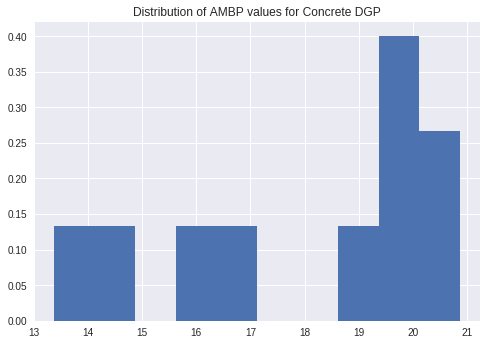

In [42]:
display_raw_performance_metrics(concrete_perf_raw, "AMBP", "Concrete DGP")

#### Sampled Performance

In [43]:
display_aggregated_performance_metrics(sampled_perf_agg)

AMBP: 20.749
AMBP (std): 26.167
RMSE: 0.154
RMSE (std): 0.132


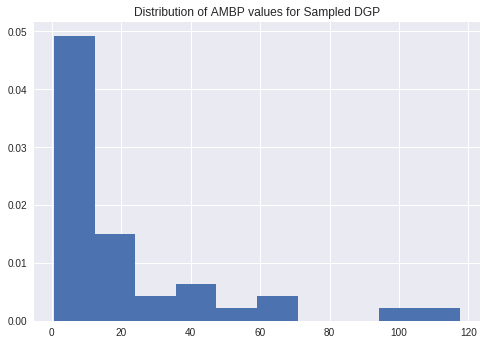

In [44]:
display_raw_performance_metrics(sampled_perf_raw, "AMBP", "Sampled DGP")

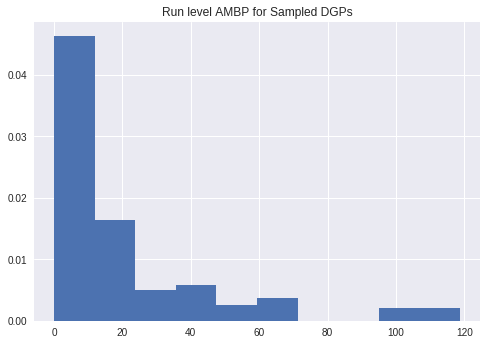

In [45]:
all_sampled_runs = [item for sublist in sampled_perf_run_raw["AMBP"] for item in sublist]
display_distro(all_sampled_runs, "Run level AMBP for Sampled DGPs")

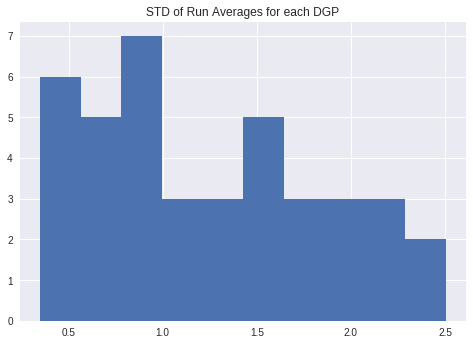

In [46]:
plt.hist(np.std(sampled_perf_run_raw["AMBP"], axis=1))
plt.title("STD of Run Averages for each DGP")
plt.show()

#### Side by Side Comparison

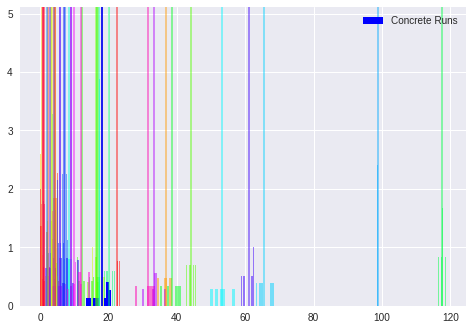

In [47]:
display_sampled_dgps_vs_concrete(sampled_perf_run_raw, concrete_perf_raw, "AMBP")

### Analysis

In [74]:
predictive_metric = "TREATMENT_NONLINEARITY Lin r2(X_obs, Treat Logit)"
performance_metric = "AMBP"
performance_metric_outlier_lim = 40
metric_domain = np.linspace(0.1, 0.95, 100)

In [75]:
sampled_metric_vals = np.array(sampled_data_raw[predictive_metric])
sampled_perf_vals = np.array(sampled_perf_raw[performance_metric])
sampled_perf_run_vals = np.array(sampled_perf_run_raw[performance_metric])

outlier_locs = sampled_perf_vals > performance_metric_outlier_lim
num_outliers = np.sum(outlier_locs)
print(f"Removing {num_outliers} outliers. {performance_metric}s: {sampled_perf_vals[outlier_locs]}")
outlier_filter = sampled_perf_vals < performance_metric_outlier_lim

sampled_metric_vals = sampled_metric_vals[outlier_filter]
sampled_perf_vals = sampled_perf_vals[outlier_filter]
sampled_perf_run_vals = sampled_perf_run_vals[outlier_filter, :]

concrete_metric_vals = np.array(concrete_data_raw[predictive_metric])
concrete_perf_vals = np.array(concrete_perf_raw[performance_metric])


Removing 6 outliers. AMBPs: [ 44.277 117.564  53.087  65.601  98.716  61.021]


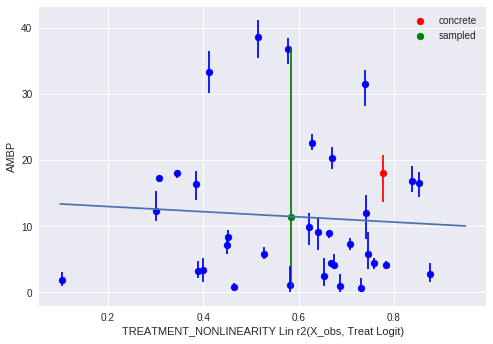

R^2 0.004484945133798739 P 0.7066835006715573


In [76]:
plot_dgp_metric_vs_perf(concrete_metric_vals, concrete_perf_vals,
                        "r", "concrete")

plot_dgp_metric_vs_perf(sampled_metric_vals, sampled_perf_vals,
                        "g", "sampled")

plt.ylabel(performance_metric)
plt.xlabel(predictive_metric)

for sample_metric_val, sampled_dgp_runs in zip(sampled_metric_vals, sampled_perf_run_vals):
    plot_dgp_metric_vs_perf(sample_metric_val, sampled_dgp_runs, "b", None)

grad, intr, r, p, _ = st.linregress(sampled_metric_vals, sampled_perf_vals)
plt.plot(metric_domain, grad*metric_domain + intr)
plt.legend()
plt.show()
print("R^2", r**2, "P", p)
# grad, intr, r, p, _, sampled_perf_raw["AMBP"]

In [58]:

category_data = get_term_category_data(dgps)

categories = [
    Constants.DGPSampling.INTERACTION_TWO_WAY,
    Constants.DGPSampling.POLY_QUADRATIC,
    Constants.DGPSampling.LINEAR,
]

category_count_data = {}
for category in categories:
    category_counts = list(map(lambda data: data[0][category], category_data))
    category_count_data[category] = category_counts
    print(category, np.mean(category_counts), np.std(category_counts))

INTERACTION_TWO_WAY 12.175 3.169286197237479
POLY_QUAD 3.175 0.7709571972554637
LINEAR 6.525 1.303600782448369


In [64]:
# Categorize the interaction terms in terms of presence 
# of binary covars as neither, one or both components
# for in each DGP
binary_data = []
for data in category_data:    
    interactions = data[1][Constants.DGPSampling.INTERACTION_TWO_WAY]
    get_is_binary_statuses = lambda var_name: int(str(var_name)[1:]) in GENMATCH_BINARY_COVAR_INDECES
    
    interaction_binary_classes = [
        categorize_interaction_two_way([
            get_is_binary_statuses(interaction_var)
            for interaction_var in interaction_vars
        ])
        for interaction_vars in interactions
    ]
    
    binary_data.append(np.array(interaction_binary_classes))

both_counts = np.array([np.sum(binary_datum == "both") for binary_datum in binary_data])
one_counts = np.array([np.sum(binary_datum == "one") for binary_datum in binary_data])
both_counts = both_counts[outlier_filter]
one_counts = one_counts[outlier_filter]
# one_counts = np.sum(binary_data == "one", axis=1)[outlier_filter]

R^2 0.0996661198697135 P 0.04720914046753699


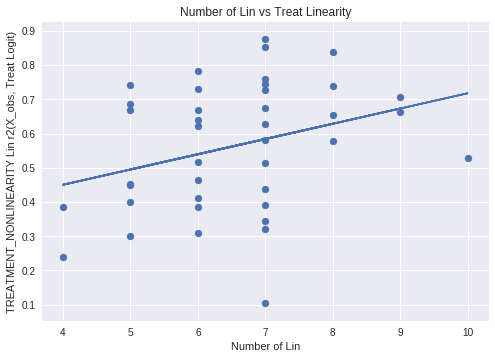

In [73]:
lin_counts = np.array(category_count_data["LINEAR"])[outlier_filter]
plt.title("Number of Lin vs Treat Linearity")
plt.ylabel(predictive_metric)
plt.xlabel("Number of Lin")
plt.scatter(lin_counts, sampled_metric_vals)

# regression plot
slope, intr, r_value, p_value, _ = st.linregress(
   lin_counts, sampled_metric_vals)
print("R^2", r_value**2, "P", p_value)
plt.plot(lin_counts, slope*lin_counts + intr)
plt.show()

R^2 0.04280216521341232 P 0.20023358005662178


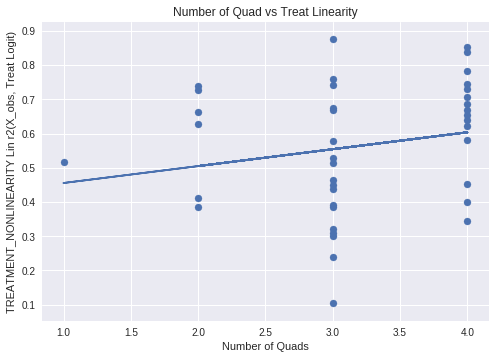

In [72]:
quad_counts = np.array(category_count_data["POLY_QUAD"])[outlier_filter]
plt.title("Number of Quad vs Treat Linearity")
plt.ylabel(predictive_metric)
plt.xlabel("Number of Quads")
plt.scatter(quad_counts, sampled_metric_vals)

# regression plot
slope, intr, r_value, p_value, _ = st.linregress(
   quad_counts, sampled_metric_vals)
print("R^2", r_value**2, "P", p_value)
plt.plot(quad_counts, slope*quad_counts + intr)
plt.show()

R^2 0.021996550618472763 P 0.36106869172134726


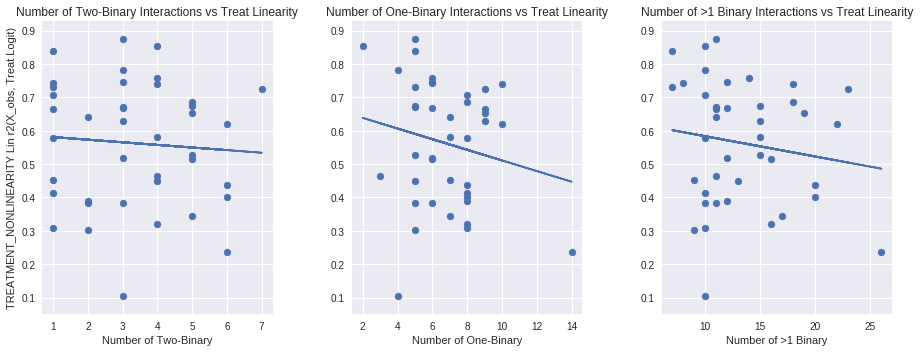

In [68]:
plt.figure(figsize=(13, 5))

plt.subplot(131)
plt.title("Number of Two-Binary Interactions vs Treat Linearity")
plt.ylabel(predictive_metric)
plt.xlabel("Number of Two-Binary")
plt.scatter(both_counts, sampled_metric_vals)

# regression plot
slope, intr, r_value, p_value, _ = st.linregress(
   both_counts, sampled_metric_vals)
plt.plot(both_counts, slope*both_counts + intr)

plt.subplot(132)
plt.title("Number of One-Binary Interactions vs Treat Linearity")
plt.xlabel("Number of One-Binary")
plt.scatter(one_counts, sampled_metric_vals)

# regression plot
slope, intr, r_value, p_value, _ = st.linregress(
   one_counts, sampled_metric_vals)
plt.plot(one_counts, slope*one_counts + intr)

plt.subplot(133)
plt.title("Number of >1 Binary Interactions vs Treat Linearity")
plt.xlabel("Number of >1 Binary")
aggregated_binary_counts = 2*both_counts + one_counts
plt.scatter(aggregated_binary_counts, sampled_metric_vals)

# regression plot
slope, intr, r_value, p_value, _ = st.linregress(
   aggregated_binary_counts, sampled_metric_vals)
plt.plot(aggregated_binary_counts, slope*aggregated_binary_counts + intr)

print("R^2", r_value**2, "P", p_value)
plt.tight_layout()
plt.show()

# The choice of binary interactions matters for the metric (which we know)
# is correlated with the performance of the estimator.

R^2 0.021676483786206843 P 0.3646250464159494


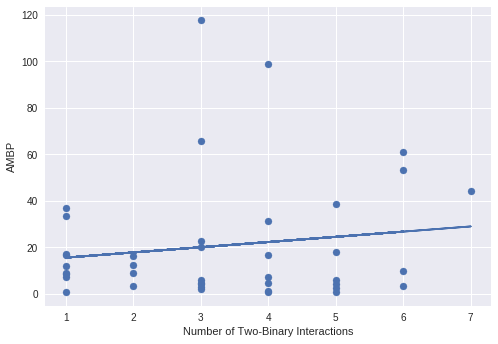

In [69]:
plt.scatter(both_counts, sampled_perf_vals)
plt.xlabel("Number of Two-Binary Interactions")
plt.ylabel(performance_metric)
# regression plot
slope, intercept, r_value, p_value, _ = st.linregress(both_counts, sampled_perf_vals)
plt.plot(both_counts, slope*both_counts + intercept)

print("R^2", r_value**2, "P", p_value)
plt.show()

R^2 0.04758010154679688 P 0.17632148352549953


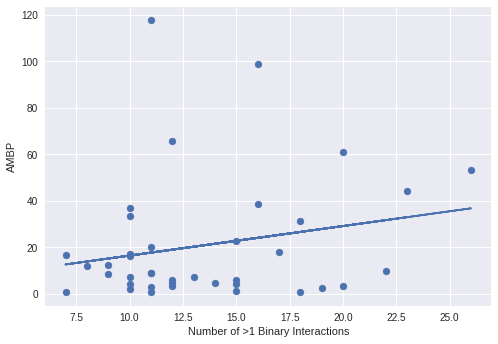

In [70]:
plt.scatter(aggregated_binary_counts, sampled_perf_vals)
plt.xlabel("Number of >1 Binary Interactions")
plt.ylabel(performance_metric)
# regression plot
slope, intercept, r_value, p_value, _ = st.linregress(aggregated_binary_counts, sampled_perf_vals)
plt.plot(aggregated_binary_counts, slope*aggregated_binary_counts + intercept)

print("R^2", r_value**2, "P", p_value)
plt.show()

# The choice of binary interactions matters for performance of the estimator.

## Narrative

Authors create a semi realistic data set - mix of binary and normal covariates.

The hand-select a set of functions with escalating levels of nonlinearity and non-additivity.

This analysis will show why this is a problematic strategy. Instead of tuning Maccabee to sample from specific location: sample functions which look very similar to their function in terms of expected structure.

Keep everything else constant: same data, same constant treatment effect, same lack of outcome noise, same coeff distro (by inspection) *TODO verify this distr via histogram*. *TODO: see what happens with non-dynamic datasets*.

This is a much lower variance setting than a standard maccabee sampler: normally would sample a wide class of functions with similar metrics. Here, we sample from the class of functions. Implication is that variance in this class is a subset of wider variance we would expect from the universe of possible functional forms could have selected.

The results show the following:
- We do indeed sample from universe of same structure functions. Ratio of components is identical.
- There is a wide distro over performance
- Digging into this, we see one contributing factor is a distro over the treatment assignment metric. **IE, identical structure** is producing highly varied non-linearity metrics.
- It could be that this metric is useless but we see that it is indeed strongly correlated with performance of the estimator. So the metric matters.

It appears the variance comes from different distro over binary variables in the interactions. This is logical given it is the only real difference.

**Key take-aways**

- Hand specified forms are a single sample from a (potentially wide) distribution over **realized** value of targeted distributional setting as proxied by values of metrics. And these distributional setting are correlated to performance (again, via metrics) (as is expected)

- This would be even wider if we sampled from a wider class of variables (*TODO relax the constrains by moving back to soft sampler and see what happens*)

- Even within a single metric setting, there is variance from other factors - both data set and other distributional setting values. This means that even with in a fixed target, there is a need for averaging.

- So to really test a method, must sample by targeting distributional metrics. In practice, this means average over many realizations with the correct - on average metric value. Any single is hard to find and may not capture range of other possible distributional settings. 

Put formally, we want the conditional marginal over a specific distributional setting.



In [31]:
# TRUE_TREAT_LOGIT = dgp.treatment_logit_expression

# class GenmatchEquivDataGeneratingProcess(SampledDataGeneratingProcess):
#     @data_generating_method(Constants.DGPVariables.OUTCOME_NOISE_NAME, [])
#     def _generate_outcome_noise_samples(self, input_vars):
#         return 0
    
#     @data_generating_method(Constants.DGPVariables.TREATMENT_EFFECT_NAME, [])
#     def _generate_treatment_effects(self, input_vars):
#         return -0.4
    
#     @data_generating_method(Constants.DGPVariables.PROPENSITY_SCORE_NAME,
#                             [Constants.DGPVariables.COVARIATES_NAME])
#     def _generate_true_propensity_scores(self, input_vars):
#         observed_covariate_data = input_vars[Constants.DGPVariables.COVARIATES_NAME]

#         logits = evaluate_expression(
#             TRUE_TREAT_LOGIT,
#             observed_covariate_data)

#         return 1/(1 + np.exp(-1*logits))